### Make imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.distributions as dist

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from BayesianNN.VAE import Encoder, Decoder, VAE

In [5]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

### Load data

In [6]:
batch_size=1024

In [7]:
trans = transforms.ToTensor()

In [8]:
mnist_train = datasets.MNIST("./data/", train=True, transform=trans)

In [9]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

In [10]:
mnist_test = datasets.MNIST("./data/", train=False, transform=trans)

In [11]:
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

In [12]:
iterator = enumerate(test_loader)

In [13]:
batch_id, (data, label) = next(iterator)

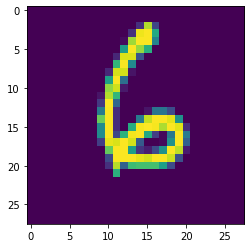

In [16]:
i = np.random.choice(batch_size)
plt.imshow(data[i].reshape(28, 28))

### instantiate the VAE

In [15]:
encoder = Encoder(layers=[28*28, 128], z_dim=2)

In [16]:
decoder = Decoder(layers=[2, 128], output_dim=28*28)

In [17]:
vae = VAE(encoder=encoder, decoder=decoder)

### Prepare for Variational inference

In [18]:
optim = Adam({"lr":0.0005})

In [19]:
svi = SVI(model=vae.model, guide=vae.guide, optim=optim, loss=Trace_ELBO())

### Loop and optimization

In [20]:
train_loader.batch_size

1024

In [21]:
epochs = 100
N = len(train_loader)*train_loader.batch_size

In [22]:
for iep in range(epochs):
    ### remember, step passes to model and guide the same arguments
    loss = 0.
    for batch_id, (data, label) in enumerate(train_loader):
        x = data.view(-1, 28*28).cuda()
        loss += svi.step(x, x)/float(N)
    
    if iep%5==0:
        print("Epoch: {} - Loss: {}".format(iep, loss))
    
    

Epoch: 0 - Loss: 322.16979409678504
Epoch: 5 - Loss: 187.90034320142314
Epoch: 10 - Loss: 179.58841702056327
Epoch: 15 - Loss: 175.5456661195258
Epoch: 20 - Loss: 173.36152224293198
Epoch: 25 - Loss: 172.11645412697632
Epoch: 30 - Loss: 171.209641574803
Epoch: 35 - Loss: 170.30383270776875
Epoch: 40 - Loss: 169.2857401956946
Epoch: 45 - Loss: 168.37571017822975
Epoch: 50 - Loss: 167.6156665056439
Epoch: 55 - Loss: 166.9770120210567
Epoch: 60 - Loss: 166.41135341131073
Epoch: 65 - Loss: 165.88237521304922
Epoch: 70 - Loss: 165.36269731844888
Epoch: 75 - Loss: 164.8773994223546
Epoch: 80 - Loss: 164.38074253777333
Epoch: 85 - Loss: 163.92730621968283
Epoch: 90 - Loss: 163.47010730484783
Epoch: 95 - Loss: 163.0601147089974


In [23]:
#torch.save(vae.state_dict(), "./vae_weights_2D.pkl")

In [33]:
vae.requires_grad_(False)

VAE(
  (encoder): Encoder(
    (activation): Softplus(beta=1, threshold=20)
    (layer0): Linear(in_features=784, out_features=400, bias=True)
    (mean): Linear(in_features=400, out_features=50, bias=True)
    (log_var): Linear(in_features=400, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (activation): Softplus(beta=1, threshold=20)
    (out_activation): Sigmoid()
    (layer0): Linear(in_features=50, out_features=400, bias=True)
    (output): Linear(in_features=400, out_features=784, bias=True)
  )
)

In [34]:
from pyro.infer import Predictive

In [35]:
batch_id, (data, label) = next(iterator)

In [36]:
prediction = Predictive(model = vae.model, guide=vae.guide, num_samples=1 , return_sites=["obs", "_RETURN"])

In [37]:
pred = prediction(data.view(-1, 28*28).cuda())

/disk/users/nserra/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/pyro/primitives.py:360: UserWarning: layer0.weight was not registered in the param store because requires_grad=False
  warnings.warn("{} was not registered in the param store because".format(param_name) +
/disk/users/nserra/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/pyro/primitives.py:360: UserWarning: layer0.bias was not registered in the param store because requires_grad=False
  warnings.warn("{} was not registered in the param store because".format(param_name) +
/disk/users/nserra/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/pyro/primitives.py:360: UserWarning: mean.weight was not registered in the param store because requires_grad=False
  warnings.warn("{} was not registered in the param store because".format(param_name) +
/disk/users/nserra/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/pyro/primitives.py:360: UserWarning: mean.bias was not registered in the param store because requires_grad=Fa

In [38]:
x = pred["obs"]

In [39]:
pred.keys()

dict_keys(['obs', '_RETURN'])

In [40]:
x.shape

torch.Size([1, 128, 784])

In [41]:
i = np.random.choice(90)
a = x[0, i].view(28, 28).cpu()

In [42]:
print(i)

0


In [43]:
b = data.cpu()

In [44]:
b.shape

torch.Size([128, 1, 28, 28])

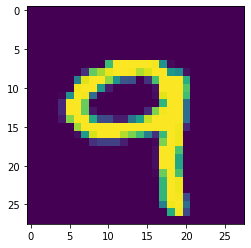

In [45]:
plt.imshow(b[i, 0])

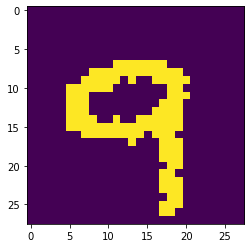

In [46]:
plt.imshow(a)

In [67]:
reco = vae.reconstruction(data.view(-1, 28*28).cuda())

In [68]:
x = reco.view(-1, 28, 28).cpu()

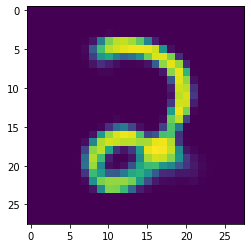

In [74]:
i = np.random.choice(x.shape[0])
plt.imshow(x[i])

### Generating from zeros

In [ ]:
zeros = torch.zeros([256, 784])

In [ ]:
yhat = vae.model(zeros)

In [ ]:
img = yhat.view(-1, 28, 28).cpu().data.numpy()

In [ ]:
i = np.random.choice(256)
plt.imshow(img[i])